In [1]:
import pickle
from time import time

import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.rdinchi import InchiToMol
from rdkit.Chem import MolFromSmiles as MolFromSmiles
from rdkit.Chem.AllChem import EmbedMolecule, MMFFOptimizeMolecule
from rdkit import DataStructs

from mordred import Calculator, descriptors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250


import pubchempy as pc

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

RDKit WARNING: [03:38:09] Enabling RDKit 2019.09.3 jupyter extensions


In [14]:
ls

NaN_Feature_Heatmap.png             mae_vs_mse_scores.csv*
NaN_Only_Feature_Heatmap.png        processed_data.csv*
RT_Predictor_TD.ipynb               products_1.csv
RetentionTime_ML.ipynb              rt_data.csv
SMRT_dataset.csv                    rt_data.xlsx
all_rt_data.csv*                    rt_data_hist.png
feature_selection_scores.csv        scores_by_tree_count.pickle*
fiehn_feature_selection_scores.csv* smrt_inchis
final_RT_model.pickle*


In [9]:
SMRT_data = pd.read_csv('SMRT_dataset.csv',";")

In [10]:
SMRT_data

pubchem     rt                                              inchi
0          5139   93.5    InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)
1          3505  687.8  InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...
2          2159  590.7  InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...
3          1340  583.6  InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...
4          3344  579.0  InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...
...         ...    ...                                                ...
80033  97733655  946.4  InChI=1S/C25H29N3O6S/c1-5-24(29)26-25-17(4)27-...
80034  98666786  653.1  InChI=1S/C17H24FN3O5S/c1-25-7-3-6-19-17(22)20-...
80035  98670835  648.2  InChI=1S/C17H25N3O5S/c1-13-4-3-5-16(8-13)26(22...
80036  98779314  783.9  InChI=1S/C21H25N3O4S/c1-15-7-9-19(10-8-15)29(2...
80037  99905419  603.7  InChI=1S/C14H16N2O2/c17-13-11-8-15-9-12(11)14(...

[80038 rows x 3 columns]

In [11]:
smrt_inchi =[]
tried = []

In [12]:
smrt_pubchem = SMRT_data.loc[:,'pubchem']
for i in smrt_pubchem:
    if i not in tried:
        smrt_inchi.append(pc.Compound.from_cid(i))
        tried.append(i)

KeyboardInterrupt: 

In [ ]:
len(tried)

In [ ]:
smrt_inchis = [c.inchi for c in smrt_inchi]
smrt_mol = [InchiToMol(x, sanitize=True)[0] for x in smrt_inchis]
smrt_fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in smrt_mol]

In [75]:
product_data = pd.read_csv('products.csv')
product_data

Intermediates  \
0                            CSCCC(=O)C(O)(CCSC)C(=O)O   
1    CSCCC(=O)C(O)(Cc1ccc(O)cc1)C(=O)O;CSCCC(O)(C(=...   
2    CCCCCCC(O)(C(=O)O)C(=O)CCSC;CCCCCCC(=O)C(O)(CC...   
3    CSCCC(=O)C(O)(Cc1cnc[nH]1)C(=O)O;CSCCC(O)(C(=O...   
4    CSCCC(=O)C(O)(CCCC(=O)O)C(=O)O;CSCCC(O)(C(=O)O...   
..                                                 ...   
460  CCOC(=O)c1csc(C(C#N)C(=O)C(O)(NC2(c3ccc(Cl)s3)...   
461  CCOC(=O)c1csc(C(C#N)C(=O)C(O)(Nc2sc3c(c2C(=O)O...   
462  O=C(O)C(O)(NC1(c2ccc(Cl)s2)CCCCC1)C(=O)NC1(c2c...   
463  O=C(O)c1c(NC(=O)C(O)(NC2(c3ccc(Cl)s3)CCCCC2)C(...   
464  O=C(O)c1c(NC(=O)C(O)(Nc2sc3c(c2C(=O)O)CCCC3)C(...   

                             CO2_Fall_Off_Intermediate  
0                                    CSCCC(=O)C(O)CCSC  
1    CSCCC(O)C(=O)Cc1ccc(O)cc1;CSCCC(=O)C(O)Cc1ccc(...  
2              CCCCCCC(=O)C(O)CCSC;CCCCCCC(O)C(=O)CCSC  
3    CSCCC(O)C(=O)Cc1cnc[nH]1;CSCCC(=O)C(O)Cc1cnc[nH]1  
4        CSCCC(=O)C(O)CCCC(=O)O;CSCCC(O)C(=O)CCCC(=O)O  
..                                                 ...  
460  CCOC(=O)c1csc(C(C#N)C(=O)C(O)NC2(c3ccc(Cl)s3)C...  
461  CCOC(=O)c1csc(C(C#N)C(=O)C(O)Nc2sc3c(c2C(=O)O)...  
462  O=C(NC1(c2ccc(Cl)s2)CCCCC1)C(O)NC1(c2ccc(Cl)s2...  
463  O=C(O)c1c(NC(O)C(=O)NC2(c3ccc(Cl)s3)CCCCC2)sc2...  
464  O=C(O)c1c(NC(=O)C(O)Nc2sc3c(c2C(=O)O)CCCC3)sc2...  

[465 rows x 2 columns]

In [76]:
product_smiles = product_data.loc[:,'Intermediates']
product_mol = [MolFromSmiles(x.split(';')[0]) for x in product_smiles]

In [77]:
product_2_smiles = product_data.loc[:,'CO2_Fall_Off_Intermediate']
product_2_mol = [MolFromSmiles(x.split(';')[0]) for x in product_2_smiles]

In [86]:
def calc_distances(smile):
    query_mol = MolFromSmiles(smile.split(';')[0])
    query_fp = Chem.AllChem.GetMorganFingerprintAsBitVect(query_mol, 2)
    return DataStructs.BulkTanimotoSimilarity(query_fp, smrt_fps)   

In [87]:
distances = [[s, calc_distances(s)] for s in product_smiles]

In [88]:
distances_2 = [[s, calc_distances(s)] for s in product_2_smiles]

In [136]:
len(distances[0][1])

80038

In [95]:
df = pd.DataFrame(distances)

In [127]:
m = 0.5
for i in range(len(df)):
    count = len([c for c in df.loc[i,1] if c > m]) 
    df.loc[i,'count']=count

In [128]:
df['count'].sum(axis=0)

0.0

In [139]:
df_2 = pd.DataFrame(distances_2)
m = 0.4
for i in range(len(df)):
    count = len([c for c in df.loc[i,1] if c > m]) 
    df_2.loc[i,'count']=count

In [140]:
df_2['count'].sum(axis=0)

120.0

In [147]:
df_2['count'].plot.hist

<bound method PlotAccessor.hist of <pandas.plotting._core.PlotAccessor object at 0x1b1c054310>>

In [2]:
rt_csv_data = pd.read_csv('rt_data.csv')
rt_csv_data

SMILES  \
0                           CSCCC(=O)C(=O)O   
1                   O=C(O)C(=O)Cc1ccc(O)cc1   
2                         CCCCCCC(=O)C(=O)O   
3                    O=C(O)C(=O)Cc1cnc[nH]1   
4                      O=C(O)CCCC(=O)C(=O)O   
5                       CC(C)(C)C(=O)C(=O)O   
6                       O=C(O)C(=O)C(F)(F)F   
7              Cc1cc(C)c(C(=O)C(=O)O)c(C)c1   
8                         OC(=O)C(=O)C(C)CC   
9                             CCC(=O)C(=O)O   
10                     O=C(O)C(=O)Cc1ccccc1   
11                           CCCC(=O)C(=O)O   
12                        CC(C)CC(=O)C(=O)O   
13                      O=C(O)CCC(=O)C(=O)O   
14                             CC(=O)C(=O)O   
15                   O=C(O)CCCCCC(=O)C(=O)O   
16                      O=C(O)C(=O)c1ccccc1   
17              O=C(O)C(=O)c1c[nH]c2ccccc12   
18                       O=C(O)CC(=O)C(=O)O   
19                            O=C(O)C(=O)CO   
20                     OC(=O)C(=O)CCc1cccs1   
21                     CC(C)N(O)C(=O)C(O)=O   
22       CCOC(=O)c1csc(n1)C(C#N)C(=O)C(O)=O   
23        OC(=O)C(=O)NC1(CCCCC1)c1ccc(Cl)s1   
24          OC(=O)C(=O)Nc1sc2CCCCc2c1C(O)=O   
25               CC(=O)C(O)(C(=O)O)C(C)(C)C   
26                       CC(=O)C(O)C(C)(C)C   
27                        CCC(C)C(O)C(=O)CO   
28  O=C(Cc1ccc2ccccc2n1)C(O)Cc1ccc2ccccc2n1   
29   O=C(O)C(O)(CCc1cccs1)C(=O)Cc1ccc(O)cc1   
30          CCCC(=O)C(O)(Cc1cnc[nH]1)C(=O)O   
31          O=C(O)CCCCCC(=O)C(O)CCCCCC(=O)O   

                                   SMILES2      mass         m/z        RT  
0                                      NaN  148.0194  147.011575  0.310000  
1                                      NaN  180.0423  179.034475  0.360000  
2                                      NaN  158.0943  157.086475  2.370000  
3                                      NaN  154.0378  153.029975  0.110000  
4                                      NaN  160.0372  159.029375  0.160000  
5                                      NaN  130.0630  129.055175  0.460000  
6                                      NaN  141.9878  140.979975  0.130000  
7                                      NaN  192.0786  191.070775  1.890000  
8                                      NaN  130.0630  129.055175  0.660000  
9                                      NaN  102.0317  101.023875  0.180000  
10                                     NaN  164.0473  163.039475  1.030000  
11                                     NaN  116.0473  115.039475  0.330000  
12                                     NaN  130.0630  129.055175  0.800000  
13                                     NaN  146.0215  145.013675  0.130000  
14                                     NaN   88.0160   87.008175  0.130000  
15                                     NaN  188.0685  187.060675  0.520000  
16                                     NaN  150.0317  149.023875  0.390000  
17                                     NaN  189.0426  188.034775  1.190000  
18                                     NaN  132.0059  130.998075  0.130000  
19                                     NaN  104.0110  103.003175  0.110000  
20                                     NaN  184.0194  183.011575  1.480000  
21                                     NaN  147.0532  146.045375  0.160000  
22                                     NaN  268.0154  267.007575  1.550000  
23                                     NaN  287.0383  286.030475  3.340000  
24                                     NaN  269.0358  268.027975  2.410000  
25              CC(C)(C)C(=O)C(C)(O)C(=O)O  174.0892  173.081813  1.367733  
26                      CC(O)C(=O)C(C)(C)C  130.0994  129.091979  1.367733  
27                       CCC(C)C(=O)C(O)CO  146.0943  145.086522  2.815917  
28                                     NaN  342.1368  341.128890  4.482433  
29  O=C(O)C(O)(Cc1ccc(O)cc1)C(=O)CCc1cccs1  320.0718  321.079524  0.229817  
30         CCCC(O)(C(=O)O)C(=O)Cc1cnc[nH]1  226.0954  225.088885  4.524783  
31                   

In [3]:
mol_list = []

from rdkit.Chem.rdchem import Mol
from rdkit.Chem import rdmolops
from rdkit.Chem import AddHs


for smiles in rt_csv_data.SMILES:
    
    mol = MolFromSmiles(smiles)   
    mol = AddHs(mol)

    #try:
    EmbedMolecule(mol)#, useRandomCoords=True)  # This calculates the 3D structure
    MMFFOptimizeMolecule(mol)  # This cleans up the 3D structure using a force field approach
#     except:
#         rdmolops.RemoveStereochemistry(mol)  # Structure calculations can fail if there are stereochemistry conflicts
#         EmbedMolecule(mol, useRandomCoords=True)  # This calculates the 3D structure
#         MMFFOptimizeMolecule(mol)  # This cleans up the 3D structure using a force field approach

    mol_list.append(mol)

In [4]:
calc = Calculator(descriptors, ignore_3D=False)

features_df = calc.pandas(mol_list, ipynb=True)

In [5]:
features_df.index = rt_csv_data.SMILES
features_df.head()

ABC     ABCGG  nAcid  nBase    SpAbs_A  \
SMILES                                                                 
CSCCC(=O)C(=O)O          5.944584  6.287591      1      0  10.175084   
O=C(O)C(=O)Cc1ccc(O)cc1  9.589507  8.788034      1      0  15.688441   
CCCCCCC(=O)C(=O)O        7.358797  7.388977      1      0  12.703861   
O=C(O)C(=O)Cc1cnc[nH]1   8.065904  8.089401      1      0  13.234606   
O=C(O)CCCC(=O)C(=O)O     7.577577  7.630553      2      0  11.946818   

                          SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A  \
SMILES                                                                       
CSCCC(=O)C(=O)O          2.083968  4.167936  10.175084  1.130565  3.018441   
O=C(O)C(=O)Cc1ccc(O)cc1  2.243107  4.486214  15.688441  1.206803  3.450509   
CCCCCCC(=O)C(=O)O        2.090964  4.181928  12.703861  1.154896  3.219617   
O=C(O)C(=O)Cc1cnc[nH]1   2.224413  4.365434  13.234606  1.203146  3.289364   
O=C(O)CCCC(=O)C(=O)O     2.101003  4.202006  11.946818  1.086074  3.227699   

                         ...     SRW10     TSRW10          MW       AMW  \
SMILES                   ...                                              
CSCCC(=O)C(=O)O          ...  8.094684  35.852159  148.019415  8.707024   
O=C(O)C(=O)Cc1ccc(O)cc1  ...  9.034438  43.368100  180.042259  8.573441   
CCCCCCC(=O)C(=O)O        ...  8.237744  38.758822  158.094294  6.323772   
O=C(O)C(=O)Cc1cnc[nH]1   ...  8.706656  53.285132  154.037842  9.061050   
O=C(O)CCCC(=O)C(=O)O     ...  8.366603  39.161524  160.037173  8.423009   

                         WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
SMILES                                                                      
CSCCC(=O)C(=O)O            102     8     34.0     34.0  4.972222  2.277778  
O=C(O)C(=O)Cc1ccc(O)cc1    268    15     60.0     65.0  5.694444  2.944444  
CCCCCCC(=O)C(=O)O          194    10     42.0     42.0  5.472222  2.777778  
O=C(O)C(=O)Cc1cnc[nH]1     165    10     50.0     54.0  4.583333  2.527778  
O=C(O)CCCC(=O)C(=O)O       186    10     44.0     44.0  6.083333  2.611111  

[5 rows x 1826 columns]

In [6]:
# Mordred leaves error messages in cells in df where value could not be calculated
# Replace all cells with error messages (strings) with np.nan using pd.to_numeric
features_df = features_df.apply(pd.to_numeric, errors='coerce')

features_df.to_csv('processed_data.csv')

features_df.head()

ABC     ABCGG  nAcid  nBase    SpAbs_A  \
SMILES                                                                 
CSCCC(=O)C(=O)O          5.944584  6.287591      1      0  10.175084   
O=C(O)C(=O)Cc1ccc(O)cc1  9.589507  8.788034      1      0  15.688441   
CCCCCCC(=O)C(=O)O        7.358797  7.388977      1      0  12.703861   
O=C(O)C(=O)Cc1cnc[nH]1   8.065904  8.089401      1      0  13.234606   
O=C(O)CCCC(=O)C(=O)O     7.577577  7.630553      2      0  11.946818   

                          SpMax_A  SpDiam_A     SpAD_A   SpMAD_A   LogEE_A  \
SMILES                                                                       
CSCCC(=O)C(=O)O          2.083968  4.167936  10.175084  1.130565  3.018441   
O=C(O)C(=O)Cc1ccc(O)cc1  2.243107  4.486214  15.688441  1.206803  3.450509   
CCCCCCC(=O)C(=O)O        2.090964  4.181928  12.703861  1.154896  3.219617   
O=C(O)C(=O)Cc1cnc[nH]1   2.224413  4.365434  13.234606  1.203146  3.289364   
O=C(O)CCCC(=O)C(=O)O     2.101003  4.202006  11.946818  1.086074  3.227699   

                         ...     SRW10     TSRW10          MW       AMW  \
SMILES                   ...                                              
CSCCC(=O)C(=O)O          ...  8.094684  35.852159  148.019415  8.707024   
O=C(O)C(=O)Cc1ccc(O)cc1  ...  9.034438  43.368100  180.042259  8.573441   
CCCCCCC(=O)C(=O)O        ...  8.237744  38.758822  158.094294  6.323772   
O=C(O)C(=O)Cc1cnc[nH]1   ...  8.706656  53.285132  154.037842  9.061050   
O=C(O)CCCC(=O)C(=O)O     ...  8.366603  39.161524  160.037173  8.423009   

                         WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
SMILES                                                                      
CSCCC(=O)C(=O)O            102     8     34.0     34.0  4.972222  2.277778  
O=C(O)C(=O)Cc1ccc(O)cc1    268    15     60.0     65.0  5.694444  2.944444  
CCCCCCC(=O)C(=O)O          194    10     42.0     42.0  5.472222  2.777778  
O=C(O)C(=O)Cc1cnc[nH]1     165    10     50.0     54.0  4.583333  2.527778  
O=C(O)CCCC(=O)C(=O)O       186    10     44.0     44.0  6.083333  2.611111  

[5 rows x 1826 columns]

In [7]:
nan_df = features_df.apply(np.isnan)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(200, 15))

sns.heatmap(nan_df, ax=ax)

In [8]:
nan_cols = nan_df.columns[(nan_df > 0).any()]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(100, 50))

sns.heatmap(nan_df[nan_cols], ax=ax)

In [9]:
print('Number of columns before dropping NaN columns:', len(features_df.columns))
features_df = features_df.dropna(axis=1, how='all')
print('Number of columns after dropping NaN columns:', len(features_df.columns))

Number of columns before dropping NaN columns: 1826
Number of columns after dropping NaN columns: 1691


In [10]:
features_df = features_df.fillna(0)  # Replace all np.nan values with 0

In [11]:
new_nan_df = features_df.apply(np.isnan)
assert not new_nan_df.isnull().sum().any()  # Make sure we have no np.nan values in our dataframe

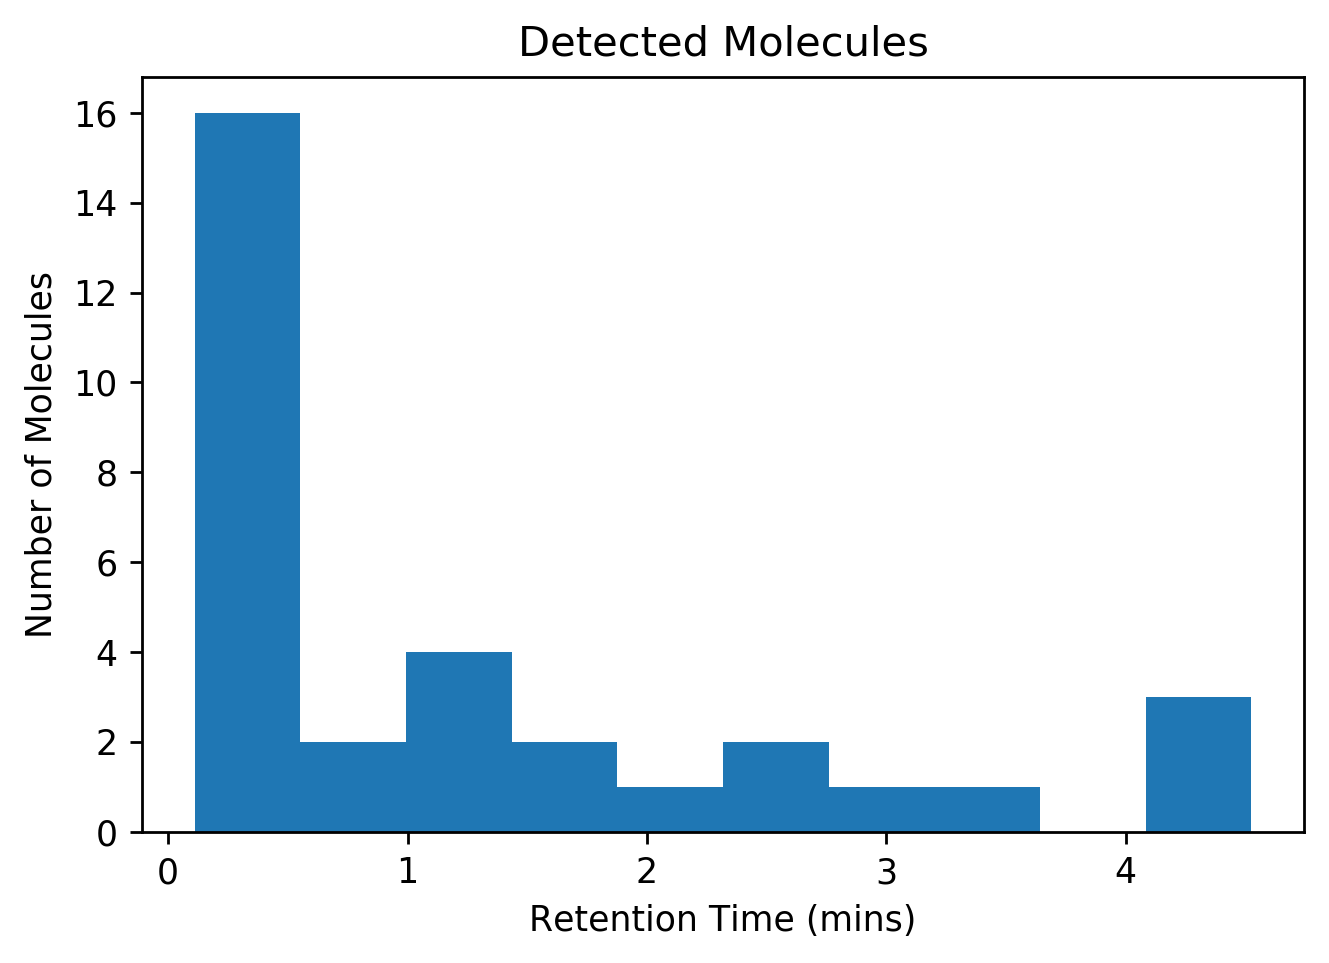

In [12]:
plt.hist(rt_csv_data.RT)
plt.xlabel('Retention Time (mins)')
plt.ylabel('Number of Molecules')
plt.title('Detected Molecules')
plt.show()

In [13]:
regr = RandomForestRegressor(oob_score=True, random_state=0, criterion='mse')
regr.fit(features_df, rt_csv_data.RT)


RandomForestRegressor(oob_score=True, random_state=0)

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


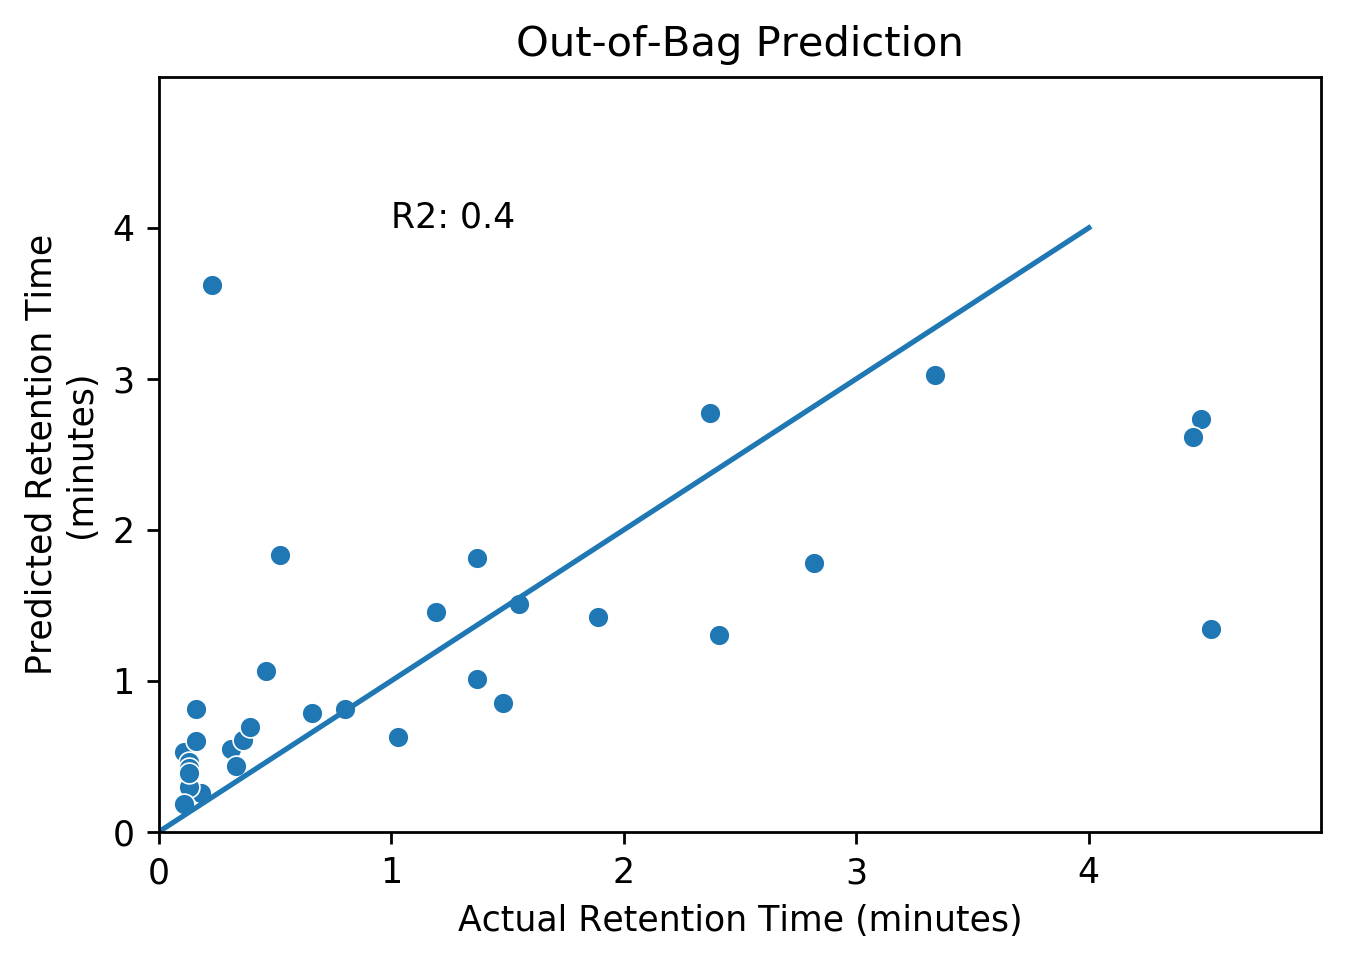

Mean Absolute Error (minutes): 0.67


In [16]:
ax = sns.scatterplot(rt_csv_data.RT, regr.oob_prediction_)
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Out-of-Bag Prediction')
ax.text(x=1, y=4, s='R2: {}'.format(round(regr.oob_score_, 2)))

ax.set_xlim(0, 5)
ax.set_xticks(range(0, 5))

ax.set_ylim(0, 5)
ax.set_yticks(range(0, 5))

sns.lineplot(range(5), range(5))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_csv_data.RT, regr.oob_prediction_), 2))

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


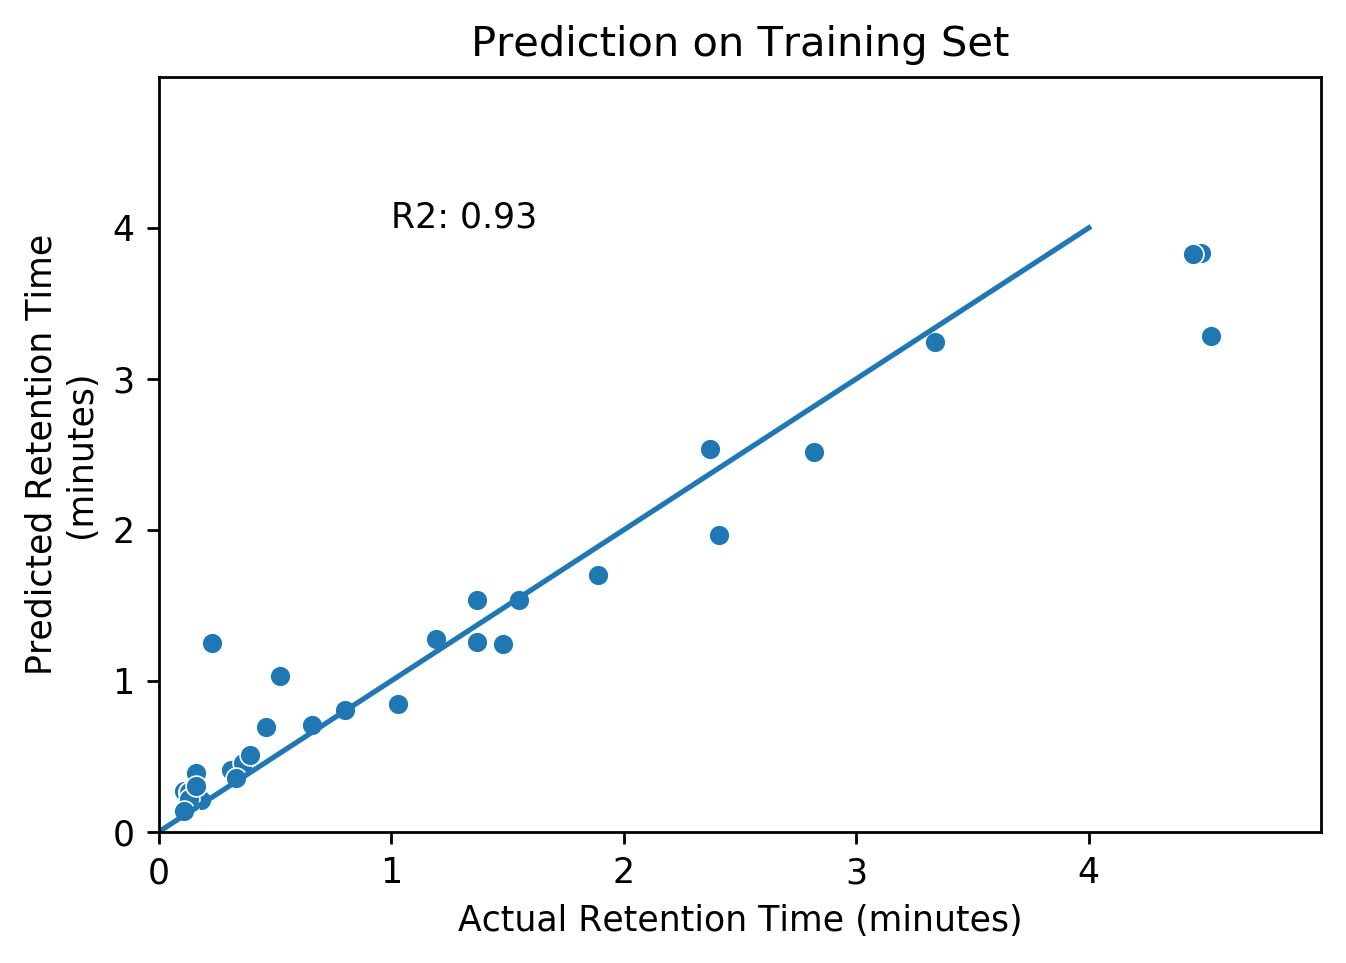

Mean Absolute Error (minutes): 0.24


In [17]:
ax = sns.scatterplot(rt_csv_data.RT, regr.predict(features_df))
ax.set_xlabel('Actual Retention Time (minutes)')
ax.set_ylabel('Predicted Retention Time\n(minutes)')
ax.set_title('Prediction on Training Set')
ax.text(x=1, y=4, s='R2: {}'.format(round(r2_score(rt_csv_data.RT, regr.predict(features_df)), 2)))

ax.set_xlim(0, 5)
ax.set_xticks(range(0, 5))

ax.set_ylim(0, 5)
ax.set_yticks(range(0, 5))

sns.lineplot(range(5), range(5))

plt.show()

print('Mean Absolute Error (minutes):', round(mean_absolute_error(rt_csv_data.RT, regr.predict(features_df)), 2))

In [52]:
rt_csv_data

SMILES  \
0                           CSCCC(=O)C(=O)O   
1                   O=C(O)C(=O)Cc1ccc(O)cc1   
2                         CCCCCCC(=O)C(=O)O   
3                    O=C(O)C(=O)Cc1cnc[nH]1   
4                      O=C(O)CCCC(=O)C(=O)O   
5                       CC(C)(C)C(=O)C(=O)O   
6                       O=C(O)C(=O)C(F)(F)F   
7              Cc1cc(C)c(C(=O)C(=O)O)c(C)c1   
8                         OC(=O)C(=O)C(C)CC   
9                             CCC(=O)C(=O)O   
10                     O=C(O)C(=O)Cc1ccccc1   
11                           CCCC(=O)C(=O)O   
12                        CC(C)CC(=O)C(=O)O   
13                      O=C(O)CCC(=O)C(=O)O   
14                             CC(=O)C(=O)O   
15                   O=C(O)CCCCCC(=O)C(=O)O   
16                      O=C(O)C(=O)c1ccccc1   
17              O=C(O)C(=O)c1c[nH]c2ccccc12   
18                       O=C(O)CC(=O)C(=O)O   
19                            O=C(O)C(=O)CO   
20                     OC(=O)C(=O)CCc1cccs1   
21                     CC(C)N(O)C(=O)C(O)=O   
22       CCOC(=O)c1csc(n1)C(C#N)C(=O)C(O)=O   
23        OC(=O)C(=O)NC1(CCCCC1)c1ccc(Cl)s1   
24          OC(=O)C(=O)Nc1sc2CCCCc2c1C(O)=O   
25               CC(=O)C(O)(C(=O)O)C(C)(C)C   
26                       CC(=O)C(O)C(C)(C)C   
27                        CCC(C)C(O)C(=O)CO   
28  O=C(Cc1ccc2ccccc2n1)C(O)Cc1ccc2ccccc2n1   
29   O=C(O)C(O)(CCc1cccs1)C(=O)Cc1ccc(O)cc1   
30          CCCC(=O)C(O)(Cc1cnc[nH]1)C(=O)O   
31          O=C(O)CCCCCC(=O)C(O)CCCCCC(=O)O   

                                   SMILES2      mass         m/z        RT  
0                                      NaN  148.0194  147.011575  0.310000  
1                                      NaN  180.0423  179.034475  0.360000  
2                                      NaN  158.0943  157.086475  2.370000  
3                                      NaN  154.0378  153.029975  0.110000  
4                                      NaN  160.0372  159.029375  0.160000  
5                                      NaN  130.0630  129.055175  0.460000  
6                                      NaN  141.9878  140.979975  0.130000  
7                                      NaN  192.0786  191.070775  1.890000  
8                                      NaN  130.0630  129.055175  0.660000  
9                                      NaN  102.0317  101.023875  0.180000  
10                                     NaN  164.0473  163.039475  1.030000  
11                                     NaN  116.0473  115.039475  0.330000  
12                                     NaN  130.0630  129.055175  0.800000  
13                                     NaN  146.0215  145.013675  0.130000  
14                                     NaN   88.0160   87.008175  0.130000  
15                                     NaN  188.0685  187.060675  0.520000  
16                                     NaN  150.0317  149.023875  0.390000  
17                                     NaN  189.0426  188.034775  1.190000  
18                                     NaN  132.0059  130.998075  0.130000  
19                                     NaN  104.0110  103.003175  0.110000  
20                                     NaN  184.0194  183.011575  1.480000  
21                                     NaN  147.0532  146.045375  0.160000  
22                                     NaN  268.0154  267.007575  1.550000  
23                                     NaN  287.0383  286.030475  3.340000  
24                                     NaN  269.0358  268.027975  2.410000  
25              CC(C)(C)C(=O)C(C)(O)C(=O)O  174.0892  173.081813  1.367733  
26                      CC(O)C(=O)C(C)(C)C  130.0994  129.091979  1.367733  
27                       CCC(C)C(=O)C(O)CO  146.0943  145.086522  2.815917  
28                                     NaN  342.1368  341.128890  4.482433  
29  O=C(O)C(O)(Cc1ccc(O)cc1)C(=O)CCc1cccs1  320.0718  321.079524  0.229817  
30         CCCC(O)(C(=O)O)C(=O)Cc1cnc[nH]1  226.0954  225.088885  4.524783  
31                   

In [54]:
for i in range(2,5):
    print(i)

2
3
4


In [64]:
from sklearn.model_selection import KFold
avg_r2 =pd.DataFrame(columns = range(2,6))
avg_mse=pd.DataFrame(columns = range(2,6))
for n in range(100):
    data = rt_csv_data.SMILES
    for k in range(2,6):
        scores_r2=[]
        score_mse=[]
        # prepare cross validation
        kfold = KFold(k, shuffle=True)
        # enumerate splits
        for train, test in kfold.split(data):
            training_features = [features_df.loc[x,:] for x in data[train]]
            training_features = pd.DataFrame(training_features)
            training_features.index = range(len(training_features))
            training_targets = [float(rt_csv_data[rt_csv_data['SMILES']==x]['RT']) for x in data[train]]

            regr = RandomForestRegressor(oob_score=True, random_state=0, criterion='mse')
            regr.fit(training_features, training_targets)

            test_features = [features_df.loc[x,:] for x in data[test]]
            test_targets = [float(rt_csv_data[rt_csv_data['SMILES']==x]['RT']) for x in data[test]]
            
            predicted_RTs = regr.predict(test_features)
            mse = round(mean_absolute_error(test_targets, predicted_RTs), 2)
            r2= round(r2_score(test_targets, predicted_RTs), 2)
            scores_r2.append(r2)
            score_mse.append(mse)
        avg_r2.loc[n,k]=np.mean(scores_r2)
        avg_mse.loc[n,k]=np.mean(score_mse)


Text(0.5, 1.0, 'K-Fold Cross Validation')

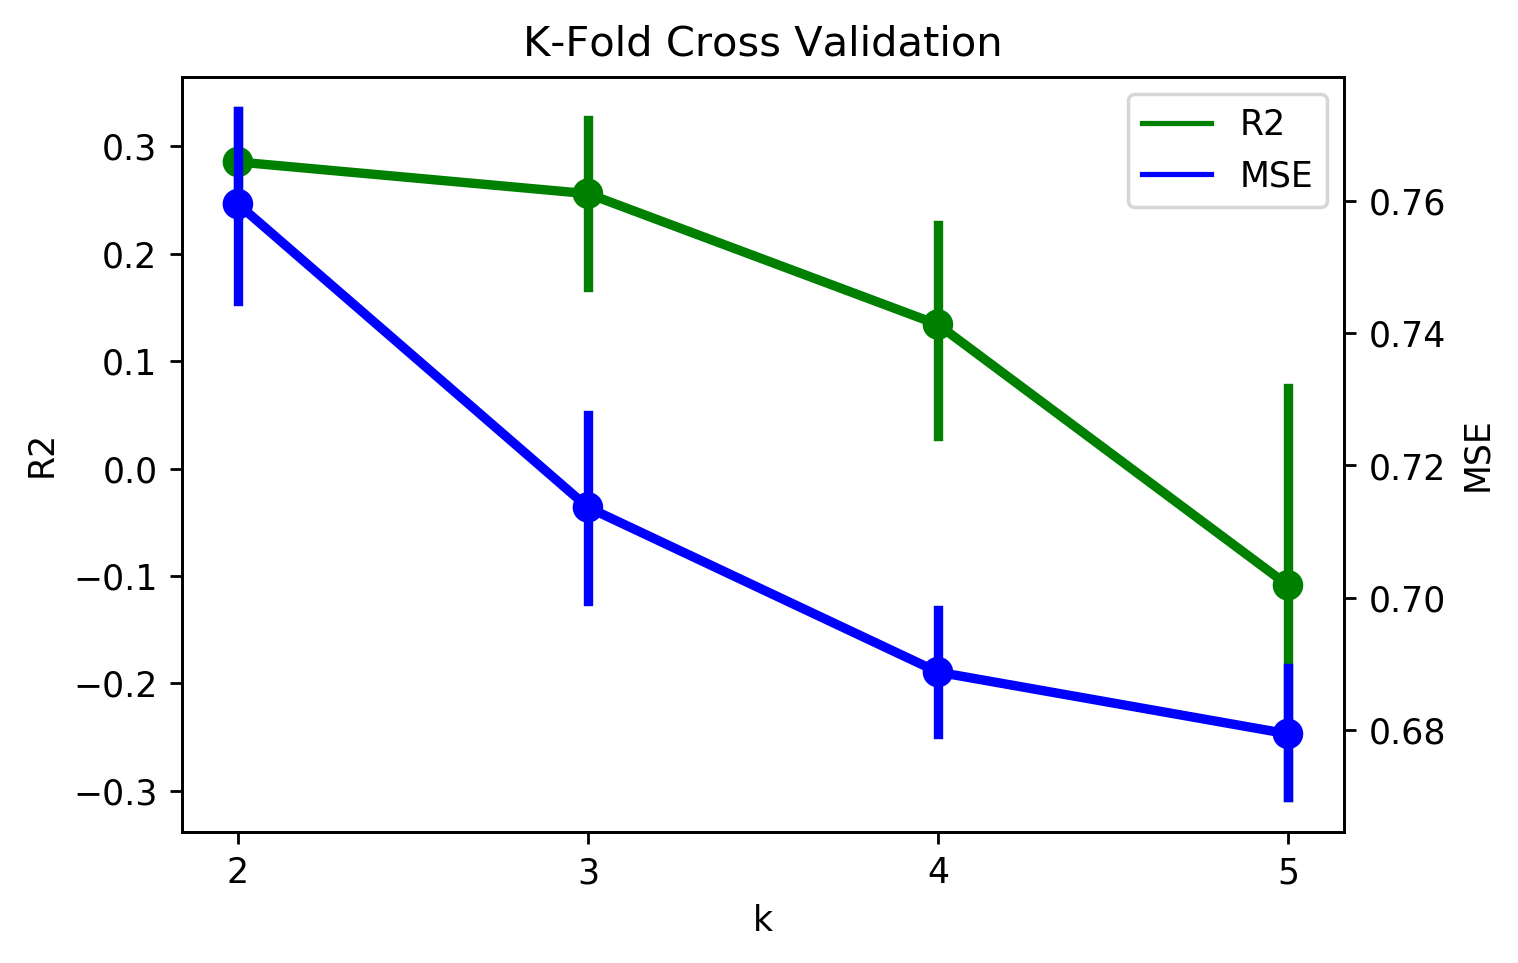

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax=sns.pointplot(data = avg_r2,color='g',label='R2')

ax2 = plt.twinx()
ax2=sns.pointplot(data = avg_mse,color='b',label='MSE')

ax.plot(np.nan, '-g', label = 'R2')
ax.plot(np.nan, '-b', label = 'MSE')
ax.legend(loc="upper right")

ax.set_xlabel("k")
ax.set_ylabel('R2')
ax2.set_ylabel('MSE')
ax.set_title('K-Fold Cross Validation')

In [82]:
data = rt_csv_data.SMILES
predictions= pd.DataFrame(columns = data)
for n in range(100):
    scores_r2=[]
    score_mse=[]
    # prepare cross validation
    kfold = KFold(3, shuffle=True)
    # enumerate splits
    for train, test in kfold.split(data):
        training_features = [features_df.loc[x,:] for x in data[train]]
        training_features = pd.DataFrame(training_features)
        training_features.index = range(len(training_features))
        training_targets = [float(rt_csv_data[rt_csv_data['SMILES']==x]['RT']) for x in data[train]]

        regr = RandomForestRegressor(oob_score=True, random_state=0, criterion='mse')
        regr.fit(training_features, training_targets)

        test_features = [features_df.loc[x,:] for x in data[test]]
        test_targets = [float(rt_csv_data[rt_csv_data['SMILES']==x]['RT']) for x in data[test]]
            
        predicted_RTs = regr.predict(test_features)
        mse = round(mean_absolute_error(test_targets, predicted_RTs), 2)
        r2= round(r2_score(test_targets, predicted_RTs), 2)
        scores_r2.append(r2)
        score_mse.append(mse)
        test_smiles = data[test]
        test_smiles.index = range(len(test_smiles))
        for t in test_smiles.index:
            predictions.loc[n,test_smiles[t]] = predicted_RTs[t]

In [124]:
predictions.mean()

SMILES
CSCCC(=O)C(=O)O                            0.890856
O=C(O)C(=O)Cc1ccc(O)cc1                    0.832159
CCCCCCC(=O)C(=O)O                          2.021728
O=C(O)C(=O)Cc1cnc[nH]1                     0.577977
O=C(O)CCCC(=O)C(=O)O                       0.821165
CC(C)(C)C(=O)C(=O)O                        0.957274
O=C(O)C(=O)C(F)(F)F                        0.522784
Cc1cc(C)c(C(=O)C(=O)O)c(C)c1               1.592149
OC(=O)C(=O)C(C)CC                          0.875782
CCC(=O)C(=O)O                              0.417530
O=C(O)C(=O)Cc1ccccc1                       0.800628
CCCC(=O)C(=O)O                             0.580209
CC(C)CC(=O)C(=O)O                          0.871124
O=C(O)CCC(=O)C(=O)O                        0.353790
CC(=O)C(=O)O                               0.448918
O=C(O)CCCCCC(=O)C(=O)O                     1.777477
O=C(O)C(=O)c1ccccc1                        0.729993
O=C(O)C(=O)c1c[nH]c2ccccc12                1.311403
O=C(O)CC(=O)C(=O)O                         0.337690
O=C(O

In [125]:
predictions.std()

SMILES
CSCCC(=O)C(=O)O                            0.215377
O=C(O)C(=O)Cc1ccc(O)cc1                    0.216587
CCCCCCC(=O)C(=O)O                          0.385435
O=C(O)C(=O)Cc1cnc[nH]1                     0.143267
O=C(O)CCCC(=O)C(=O)O                       0.266581
CC(C)(C)C(=O)C(=O)O                        0.123158
O=C(O)C(=O)C(F)(F)F                        0.123963
Cc1cc(C)c(C(=O)C(=O)O)c(C)c1               0.247980
OC(=O)C(=O)C(C)CC                          0.180533
CCC(=O)C(=O)O                              0.108402
O=C(O)C(=O)Cc1ccccc1                       0.173591
CCCC(=O)C(=O)O                             0.129295
CC(C)CC(=O)C(=O)O                          0.157553
O=C(O)CCC(=O)C(=O)O                        0.096682
CC(=O)C(=O)O                               0.123707
O=C(O)CCCCCC(=O)C(=O)O                     0.358927
O=C(O)C(=O)c1ccccc1                        0.125454
O=C(O)C(=O)c1c[nH]c2ccccc12                0.205427
O=C(O)CC(=O)C(=O)O                         0.098483
O=C(O

In [128]:
features_df.loc['CSCCC(=O)C(=O)O','MW']

148.019415116

In [129]:
MW = []
for c in predictions.columns:
    MW.append(features_df.loc[c,'MW'])

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '3-fold Cross Validation Predictions')

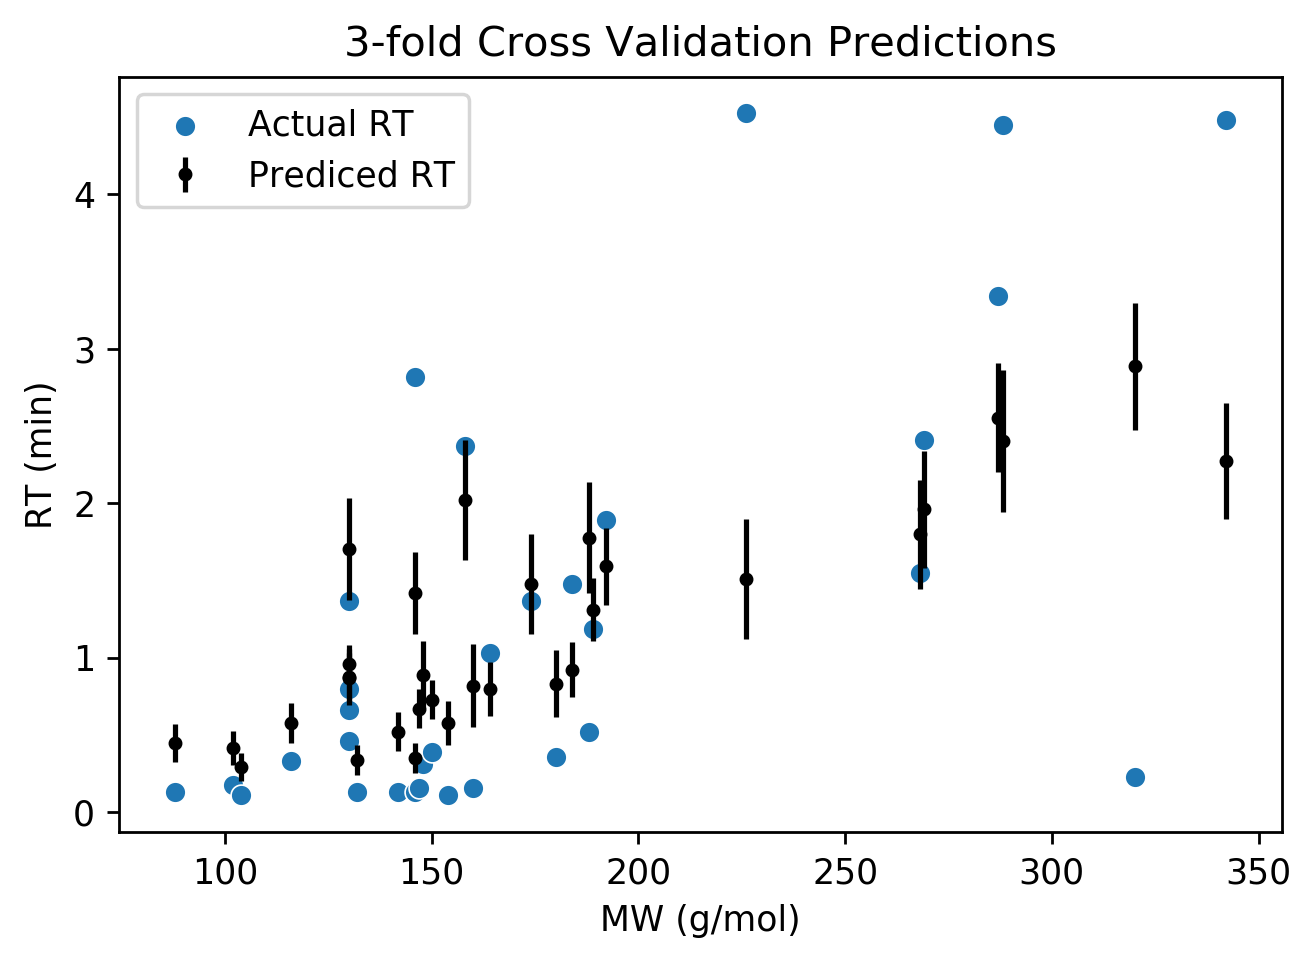

In [142]:
ax=plt.errorbar(MW,predictions.mean(), yerr=predictions.std(),fmt='.k',label='Prediced RT')
ax=sns.scatterplot(rt_csv_data.mass,rt_csv_data.RT,label='Actual RT')
plt.legend()
plt.xlabel("MW (g/mol)")
plt.ylabel('RT (min)')
plt.title('3-fold Cross Validation Predictions')

/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross Validation Predicted RTs')

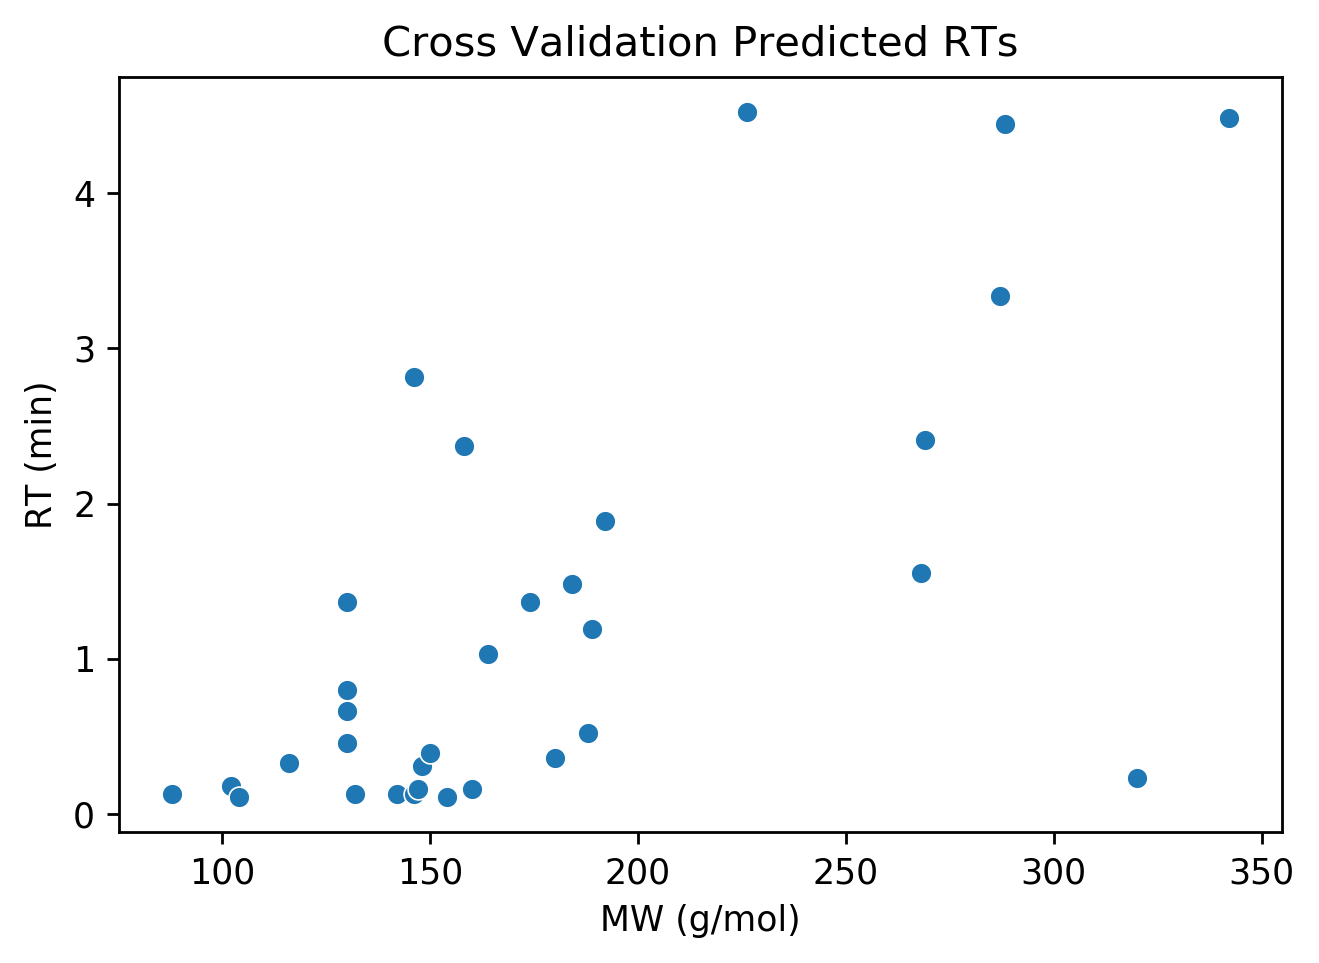

In [139]:
sns.scatterplot(rt_csv_data.mass,rt_csv_data.RT)
plt.xlabel("MW (g/mol)")
plt.ylabel('RT (min)')
plt.title('Cross Validation Predicted RTs')